In [137]:
import json
import pandas as pd 
import matplotlib as plt 
import seaborn as sns

In [127]:
import selenium

import requests
from selenium import webdriver

import time
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
nft_set = []
driver = webdriver.Chrome("C:\\Users\\brend\\chromedriver\\chromedriver_win32\\chromedriver.exe")
driver.get('https://opensea.io/rankings?sortBy=total_volume')
time.sleep(2)

lines = driver.find_elements(By.CLASS_NAME, value = 'styles__StyledLink-sc-l6elh8-0')
url_lst = [a.get_attribute('href') for a in lines]
nft_set.append(url_lst)
time.sleep(2)
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
time.sleep(2)
#nft_set[1] + nft_set[2] +nft_set[3]

for i in range(len(url_lst)):
    print(url_lst[i])


print(driver.title)

driver.quit()

url_list = url_lst[2:]
split = [i.split("/")for i in url_list]
collection_names = [i[-1] for i in split]


<ipython-input-127-7a5cf5b3848d>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome("C:\\Users\\brend\\chromedriver\\chromedriver_win32\\chromedriver.exe")


https://opensea.io/
https://opensea.io/account
https://opensea.io/collection/decentraland-wearables
https://opensea.io/collection/lootproject
https://opensea.io/collection/cryptokitties
https://opensea.io/collection/clonex
https://opensea.io/collection/cool-cats-nft
https://opensea.io/collection/meebits
https://opensea.io/collection/art-blocks
https://opensea.io/collection/sandbox
https://opensea.io/collection/rarible
https://opensea.io/collection/mutant-ape-yacht-club
https://opensea.io/collection/boredapeyachtclub
https://opensea.io/collection/decentraland
https://opensea.io/collection/cryptopunks
Top NFTs | OpenSea


In [84]:
NFT_dict ={}
for b in collection_names:
    url = f"https://api.opensea.io/api/v1/collection/{b}/stats"
    headers = {"Accept": "application/json"}
    response = requests.request("GET", url, headers=headers)
    print(response.status_code)
    nft_dict = response.json()
    NFT_dict[str(b)] = (nft_dict['stats'])
   


200
200
200
200
200
200
200
200
200
200
200
200
200


In [179]:
stats_df= pd.DataFrame(NFT_dict).T
stats_df


,one_day_volume,one_day_change,one_day_sales,one_day_average_price,seven_day_volume,seven_day_change,seven_day_sales,seven_day_average_price,thirty_day_volume,thirty_day_change,...,thirty_day_average_price,total_volume,total_sales,total_supply,count,num_owners,average_price,num_reports,market_cap,floor_price
decentraland-wearables,1.485497,1.701575,9.0,0.165055,4.363093,-0.466049,51.0,0.085551,22.010943,-0.651367,...,0.126500,83462.244889,2.297700e+04,71055.0,71055.0,10264.0,3.632426,2.0,6078.814880,0.00183
lootproject,8.978000,-0.735474,4.0,2.244500,92.914000,-0.712491,37.0,2.511189,880.854750,-0.107612,...,2.252825,73094.184806,1.114500e+04,7779.0,7779.0,2556.0,6.558473,4.0,19534.540703,2.14000
cryptokitties,6.361685,2.298114,98.0,0.064915,72.185344,1.809865,639.0,0.112966,182.147279,-0.369899,...,0.072859,70447.744970,7.772610e+05,2010589.0,2010589.0,112886.0,0.090636,2.0,227128.416444,NaN
clonex,3847.994400,0.004041,252.0,15.269819,13166.599033,1.900001,1220.0,10.792294,31069.896135,-0.336049,...,8.781768,77865.376097,9.783000e+03,18721.0,18721.0,8003.0,7.959253,6.0,202042.541395,9.10000
cool-cats-nft,391.770000,-0.327140,26.0,15.068077,3948.706024,0.308103,279.0,14.153068,13932.174513,1.775379,...,12.439442,77102.513888,2.502200e+04,9933.0,9933.0,5152.0,3.081389,2.0,140582.426292,14.35500
meebits,110.250300,-0.103138,21.0,5.250014,952.278260,0.021549,191.0,4.985750,4147.508673,0.590738,...,4.577824,82709.475750,1.542400e+04,20000.0,20000.0,5684.0,5.362388,2.0,99715.001047,4.00000
art-blocks,303.237500,0.032177,138.0,2.197373,1575.826278,1.038828,963.0,1.636372,8053.065875,-0.278992,...,2.730779,222305.628820,4.942700e+04,49323.0,49323.0,10404.0,4.497656,0.0,80710.778299,NaN
sandbox,855.900299,0.188168,211.0,4.056400,5136.597111,-0.101087,1314.0,3.909130,25065.434847,0.034093,...,4.025929,148366.795002,7.770400e+04,104273.0,104273.0,18926.0,1.909384,8.0,407616.735606,3.50000
rarible,47.259200,1.713940,32.0,1.476850,111.148195,-0.157865,2313.0,0.048054,683.513412,0.381978,...,0.058620,99495.796727,2.067157e+09,309965.0,309965.0,203962.0,0.000048,10.0,14894.963385,NaN
mutant-ape-yacht-club,1655.389733,-0.555464,73.0,22.676572,14816.922347,0.512038,751.0,19.729590,63776.328537,1.225798,...,17.316407,212970.606875,2.455700e+04,17865.0,17865.0,11589.0,8.672501,14.0,352469.131473,18.60000


In [180]:
col2_dict = {}
for i in collection_names:
    url = "https://api.opensea.io/api/v1/collection/{}".format(i)

    response = requests.request("GET", url)

    col_dict = response.json()

  
    col2_dict[str(i)] = col_dict['collection']





collection_df = pd.DataFrame(col2_dict).T

In [188]:
collection_df

,editors,payment_tokens,primary_asset_contracts,traits,stats,banner_image_url,chat_url,created_date,default_to_fiat,description,...,opensea_buyer_fee_basis_points,opensea_seller_fee_basis_points,payout_address,require_email,short_description,slug,telegram_url,twitter_username,instagram_username,wiki_url
decentraland-wearables,"[0x0239769a1adf4def9f07da824b80b9c4fcb59593, 0...","[{'id': 4645681, 'symbol': 'WETH', 'address': ...",[{'address': '0xbf53c33235cbfc22cef5a61a83484b...,{},"{'one_day_volume': 1.4854969599999999, 'one_da...",https://storage.opensea.io/static/banners/dclw...,None,2019-11-14T17:59:36.156897,False,Decentraland is an Ethereum blockchain-powered...,...,0,0,0x9a6ebe7e2a7722f8200d0ffb63a1f6406a0d7dce,False,None,decentraland-wearables,None,decentraland,None,None
lootproject,"[0x0239769a1adf4def9f07da824b80b9c4fcb59593, 0...","[{'id': 4645681, 'symbol': 'WETH', 'address': ...",[{'address': '0xff9c1b15b16263c61d017ee9f65c50...,{},"{'one_day_volume': 8.978, 'one_day_change': -0...",https://lh3.googleusercontent.com/9ZFvZ36HHtEq...,None,2021-08-27T17:48:02.860636,False,Loot is randomized adventurer gear generated a...,...,0,250,0x8cfdf9e9f7ea8c0871025318407a6f1fbc5d5a18,False,None,lootproject,None,None,None,None
cryptokitties,"[0x0239769a1adf4def9f07da824b80b9c4fcb59593, 0...","[{'id': 5098533, 'symbol': 'RFR', 'address': '...",[{'address': '0x06012c8cf97bead5deae237070f958...,"{'cooldown_index': {'min': 0, 'max': 13}, 'fan...","{'one_day_volume': 6.918675821569182, 'one_day...",https://storage.opensea.io/static/banners/cryp...,None,2019-04-26T22:13:04.207050,False,CryptoKitties is a game centered around breeda...,...,0,250,None,False,None,cryptokitties,None,CryptoKitties,None,https://opensea.readme.io/page/cryptokitties
clonex,"[0x0239769a1adf4def9f07da824b80b9c4fcb59593, 0...","[{'id': 4645681, 'symbol': 'WETH', 'address': ...",[{'address': '0x49cf6f5d44e70224e2e23fdcdd2c05...,"{'Accessories': {'cross earring': 375, 'gld ro...","{'one_day_volume': 3831.0054000000014, 'one_da...",https://lh3.googleusercontent.com/4elUtz8UyFYD...,None,2021-12-12T18:32:58.410707,False,"🧬 CLONE X 🧬\r\n\r\n20,000 next-gen Avatars, by...",...,0,250,0xe65b6865dbce299ae6a20efcc7543362540741d8,False,None,clonex,None,RTFKTstudios,RTFKTSTUDIOS,None
cool-cats-nft,"[0x0239769a1adf4def9f07da824b80b9c4fcb59593, 0...","[{'id': 4645681, 'symbol': 'WETH', 'address': ...",[{'address': '0x1a92f7381b9f03921564a437210bb9...,"{'body': {'blue cat skin': 9933}, 'face': {'al...","{'one_day_volume': 398.861, 'one_day_change': ...",https://lh3.googleusercontent.com/H4Iu36XQNJqV...,None,2021-06-27T09:03:35.403074,False,"Cool Cats is a collection of 9,999 randomly ge...",...,0,250,0xcb74075f036301b82c13df959ca9479b1ba0e660,False,None,cool-cats-nft,None,coolcatsnft,None,None
meebits,"[0x0239769a1adf4def9f07da824b80b9c4fcb59593, 0...","[{'id': 4645681, 'symbol': 'WETH', 'address': ...",[{'address': '0x7bd29408f11d2bfc23c34f18275bbf...,"{'Beard': {'big': 369, 'biker mustache': 129, ...","{'one_day_volume': 106.16029999999998, 'one_da...",https://lh3.googleusercontent.com/qwnNTSRrf9CV...,None,2021-05-03T01:32:41.897161,False,"The Meebits are 20,000 unique 3D voxel charact...",...,0,250,None,False,None,meebits,None,None,None,None
art-blocks,"[0x0239769a1adf4def9f07da824b80b9c4fcb59593, 0...","[{'id': 16596762, 'symbol': 'WIPC', 'address':...",[],"{'End Color': {'min': 15, 'max': 178}, 'Segmen...","{'one_day_volume': 285.9724999999999, 'one_day...",https://lh3.googleusercontent.com/5-KeOMqOlfC7...,None,2020-11-27T15:58:37.366034,False,Art Blocks Curated is the most strictly curate...,...,0,250,0x6c093fe8bc59e1e0cae2ec10f0b717d3d182056b,False,None,art-blocks,None,artblocks_io,artblocks_io,None
sandbox,"[0x0239769a1adf4def9f07da824b80b9c4fcb59593, 0...","[{'id': 16951009, 'symbol': 'ATRI', 'address':...",[{'address': '0x50f5474724e0ee42d9a4e711ccfb27...,"{'defense': {'min': 8, 'max': 88}, 'Land X': {...","{'one_day_volume': 855.7922990000004, 'one_day...",https://lh3.

In [201]:
collection_df.groupby('payout_address').count()

,editors,payment_tokens,primary_asset_contracts,traits,stats,banner_image_url,chat_url,created_date,default_to_fiat,description,...,only_proxied_transfers,opensea_buyer_fee_basis_points,opensea_seller_fee_basis_points,require_email,short_description,slug,telegram_url,twitter_username,instagram_username,wiki_url
payout_address,,,,,,,,,,,,,,,,,,,,,
0x6c093fe8bc59e1e0cae2ec10f0b717d3d182056b,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,0,1,0,1,1,0
0x7a9fe22691c811ea339d9b73150e6911a5343dca,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,0,1,1,1,0,0
0x8cfdf9e9f7ea8c0871025318407a6f1fbc5d5a18,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,0,1,0,0,0,0
0x9a6ebe7e2a7722f8200d0ffb63a1f6406a0d7dce,2,2,2,2,2,2,0,2,2,2,...,2,2,2,2,0,2,0,2,0,0
0xaae7ac476b117bccafe2f05f582906be44bc8ff1,2,2,2,2,2,2,0,2,2,2,...,2,2,2,2,0,2,0,1,1,0
0xcb74075f036301b82c13df959ca9479b1ba0e660,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,0,1,0,1,0,0
0xe65b6865dbce299ae6a20efcc7543362540741d8,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,0,1,0,1,1,0


In [117]:
b = collection_df.iloc[0,3] 


In [119]:
dfff = pd.json_normalize(b, sep='_')

In [ ]:
project should have begining and end - come to a conclusion and answer the question asked 

In [ ]:
needs to be concise - 10 min presentation 

In [ ]:
BEautiful ai -- presentation maker 

In [157]:
social = pd.read_csv(r"C:\Users\brend\NYCDSA\Projects\NFT\NFT-data-analysis-\tweets.zip")
social_df = pd.DataFrame(social)


In [178]:
social_df['date'] =pd.to_datetime(social_df['date']).dt.date
social_df.groupby("date")['user_followers']


In [202]:
historical_nft_data = pd.read_csv("C:\\Users\\brend\\NYCDSA\\Projects\\NFT\\NFT-data-analysis-\\archive\\NFT_Sales.csv")
hist_nft = pd.DataFrame(historical_nft_data)
hist_nft.head(25)
hist_nft.tail(25)

,Date,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
1581,2021-10-19,8.788544e+09,9745100,728534.0,5799828,69685.0,901.84,1.085974e+08,161732.0,12242.0,92047.0
1582,2021-10-20,8.878465e+09,9854022,732465.0,5863856,44894.0,901.00,8.992102e+07,108922.0,3931.0,64028.0
1583,2021-10-21,8.932410e+09,9903622,737240.0,5889879,23577.0,901.93,5.394498e+07,49600.0,4775.0,26023.0
1584,2021-10-22,8.987609e+09,9946225,748347.0,5912370,20112.0,903.62,5.519916e+07,42603.0,11107.0,22491.0
1585,2021-10-23,9.093178e+09,10068314,753316.0,5994051,40408.0,903.15,1.055694e+08,122089.0,4969.0,81681.0
1586,2021-10-24,9.166815e+09,10185622,754633.0,6063771,47588.0,899.98,7.363677e+07,117308.0,1317.0,69720.0
1587,2021-10-25,9.217393e+09,10225761,763565.0,6082659,21251.0,901.39,5.057744e+07,40139.0,8932.0,18888.0
1588,2021-10-26,9.259910e+09,10257126,767183.0,6098329,15695.0,902.78,4.251703e+07,31365.0,3618.0,15670.0
1589,2021-10-27,9.368155e+09,10397112,769282.0,6191938,46377.0,901.03,1.082452e+08,139986.0,2099.0,93609.0
1590,2021-10-28,9.407717e+09,10427209,771260.0,6207391,14644.0,902.23,3.956184e+07,30097.0,1978.0,15453.0


In [268]:
type(hist_nft.iloc[0,0])
hist_nft.Date=pd.to_datetime(hist_nft.Date)

In [246]:
hist_nft.isnull().sum()
hist_nft.Active_Market_Wallets_cumsum = hist_nft.Active_Market_Wallets_cumsum.fillna(hist_nft.Active_Market_Wallets_cumsum.mean())
hist_nft.Secondary_Sales_cumsum = hist_nft.Secondary_Sales_cumsum.fillna(hist_nft.Secondary_Sales_cumsum.mean())
hist_nft.AverageUSD_cum = hist_nft.AverageUSD_cum.fillna(hist_nft.AverageUSD_cum.mean())
hist_nft.Sales_USD  = hist_nft.Sales_USD.fillna(hist_nft.Sales_USD.mean())
hist_nft.Number_of_Sales = hist_nft.Number_of_Sales.fillna(hist_nft.Number_of_Sales.mean())
hist_nft.Active_Market_Wallets = hist_nft.Active_Market_Wallets.fillna(hist_nft.Active_Market_Wallets.mean())
hist_nft.Primary_Sales = hist_nft.Primary_Sales.fillna(hist_nft.Primary_Sales.mean())

In [249]:
hist_nft.isnull().sum()

Date                            0
Sales_USD_cumsum                0
Number_of_Sales_cumsum          0
Active_Market_Wallets_cumsum    0
Primary_Sales_cumsum            0
Secondary_Sales_cumsum          0
AverageUSD_cum                  0
Sales_USD                       0
Number_of_Sales                 0
Active_Market_Wallets           0
Primary_Sales                   0
dtype: int64

In [271]:
hist_nft.iloc[:,1:2]

,Sales_USD_cumsum
0,0.000000e+00
1,1.020300e+03
2,2.261140e+03
3,2.778690e+03
4,3.203320e+03
...,...
1601,1.008803e+10
1602,1.014001e+10
1603,1.019902e+10
1604,1.023456e+10


<AxesSubplot:xlabel='Date', ylabel='Sales_USD_cumsum'>

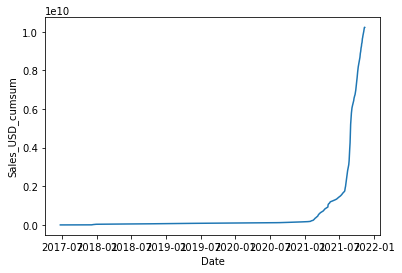

In [274]:
sumsales = hist_nft.iloc[:1]
sns.lineplot(data= "sumsales" , x=hist_nft.Date, y=hist_nft.Sales_USD_cumsum)

In [209]:
nft_sales = pd.read_csv(r"C:\Users\brend\NYCDSA\Projects\NFT\NFT-data-analysis-\nft_sales.csv")
sales_df = pd.DataFrame(nft_sales)
sales_df

,Collections,Sales,Buyers,Txns,Owners
0,Axie Infinity,"$3,328,148,500","1,079,811","9,755,511","2,656,431"
1,CryptoPunks,"$1,664,246,968","4,723","18,961","3,289"
2,Art Blocks,"$1,075,223,906","20,934","117,602","25,094"
3,Bored Ape Yacht Club,"$783,882,186","8,284","22,584","5,862"
4,NBA Top Shot,"$781,965,423","374,818","11,790,699","603,928"
...,...,...,...,...,...
245,Evolution,"$2,536,468",746,"4,961","2,061"
246,LegionPunks,"$2,535,490","1,702","3,794","2,410"
247,BabyApes,"$2,521,714","1,671","3,405","2,785"
248,Train of the Century,"$2,504,080","3,139","39,460","3,160"


In [234]:
sales_df.Sales =sales_df['Sales'].str.replace(',','')
sales_df.Sales =sales_df['Sales'].str.replace('$','')
sales_df.Sales= sales_df.Sales.astype(float)
sales_df.Buyers =sales_df['Buyers'].str.replace(',','')
sales_df.Buyers =sales_df['Buyers'].str.replace('$','')
sales_df.Txns =sales_df['Txns'].str.replace(',','')
sales_df.Txns =sales_df['Txns'].str.replace('$','')
sales_df.Owners =sales_df['Owners'].str.replace(',','')
sales_df.Owners =sales_df['Owners'].str.replace('$','')
sales_df.Buyers.astype(int)
sales_df.Owners.astype(float)
sales_df.Txns.astype(int)
sales_df


AttributeError: Can only use .str accessor with string values!

In [238]:
sales_df.Buyers =sales_df['Buyers'].str.replace(',','')
sales_df.Buyers =sales_df['Buyers'].str.replace('$','')
sales_df.Txns =sales_df['Txns'].str.replace(',','')
sales_df.Txns =sales_df['Txns'].str.replace('$','')
sales_df.Owners =sales_df['Owners'].str.replace(',','')
sales_df.Owners =sales_df['Owners'].str.replace('$','')
sales_df.Buyers.astype(int)
sales_df.Owners.astype(float)
sales_df.Txns.astype(int)

<ipython-input-238-4b89438d21c3>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  sales_df.Buyers =sales_df['Buyers'].str.replace('$','')
<ipython-input-238-4b89438d21c3>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  sales_df.Txns =sales_df['Txns'].str.replace('$','')
<ipython-input-238-4b89438d21c3>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  sales_df.Owners =sales_df['Owners'].str.replace('$','')


0       9755511
1         18961
2        117602
3         22584
4      11790699
         ...   
245        4961
246        3794
247        3405
248       39460
249        8452
Name: Txns, Length: 250, dtype: int32

<AxesSubplot:>

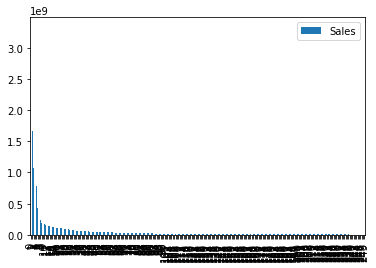